# Load data from DB

In [70]:
import mysql.connector
import pandas as pd

db = mysql.connector.connect(host='localhost',user='root',password='root', database='food_recommendation')

In [71]:
df = pd.read_sql(("""

SELECT ing.ingredient_name, recipe_id FROM food_recommendation.ingredients ing
JOIN food_recommendation.recipe_ingredients ri
ON ing.ingredient_id = ri.ingredient_id
ORDER BY recipe_id

"""), db)

In [72]:
df

,ingredient_name,recipe_id
0,white wine vinegar,415
1,salt and pepper,415
2,low fat sour cream,415
3,buttermilk,415
4,fresh tarragon,415
...,...,...
10809,unsweetened applesauce,999602
10810,baking soda,999602
10811,maple syrup,999602
10812,oat flour,999602


# Concat ingredients in to a single string

In [79]:
df['recipe_id'].unique()

array([   415,    860,    896, ..., 998213, 999278, 999602], dtype=int64)

In [76]:
df.groupby('recipe_id').transform(lambda x: ','.join(x))

,ingredient_name
0,"white wine vinegar,salt and pepper,low fat sou..."
1,"white wine vinegar,salt and pepper,low fat sou..."
2,"white wine vinegar,salt and pepper,low fat sou..."
3,"white wine vinegar,salt and pepper,low fat sou..."
4,"white wine vinegar,salt and pepper,low fat sou..."
...,...
10809,"milk,eggs,salt,vanilla,unsweetened applesauce,..."
10810,"milk,eggs,salt,vanilla,unsweetened applesauce,..."
10811,"milk,eggs,salt,vanilla,unsweetened applesauce,..."
10812,"milk,eggs,salt,vanilla,unsweetened applesauce,..."


In [85]:
df_recipe_ingredients = df.groupby('recipe_id')['ingredient_name'].transform(lambda x: ','.join(x)).drop_duplicates()
df_recipe_ingredients

0        white wine vinegar,salt and pepper,low fat sou...
15       capers,olive oil,shallots,red wine vinegar,kos...
22       coarse salt,blood oranges,green olives,unsalte...
29       oregano,paprika,olive oil,garlic clove,onion,r...
41       sea-salt,roma tomatoes,feta cheese,fresh dill,...
                               ...                        
10764    butter,cream cheese,heavy cream,salt,vanilla,s...
10774    honey,plain greek yogurt,red onion,poppy seeds...
10785    parmesan cheese,salt,olive oil,dried cranberri...
10793    vanilla ice cream,brown sugar,flour,kosher sal...
10805    milk,eggs,salt,vanilla,unsweetened applesauce,...
Name: ingredient_name, Length: 1107, dtype: object

# Add ID back in DF

In [87]:
df_recipe_ingredients= pd.DataFrame(list(zip(df['recipe_id'].unique(), df_recipe_ingredients.to_list())), columns = ['id','ingredients'])
df_recipe_ingredients

,id,ingredients
0,415,"white wine vinegar,salt and pepper,low fat sou..."
1,860,"capers,olive oil,shallots,red wine vinegar,kos..."
2,896,"coarse salt,blood oranges,green olives,unsalte..."
3,3131,"oregano,paprika,olive oil,garlic clove,onion,r..."
4,3642,"sea-salt,roma tomatoes,feta cheese,fresh dill,..."
...,...,...
1102,993892,"butter,cream cheese,heavy cream,salt,vanilla,s..."
1103,996399,"honey,plain greek yogurt,red onion,poppy seeds..."
1104,998213,"parmesan cheese,salt,olive oil,dried cranberri..."
1105,999278,"vanilla ice cream,brown sugar,flour,kosher sal..."


# Initialise df to store PMI

In [168]:
ingredients = df['ingredient_name'].unique()
df_pmi = pd.DataFrame(index = ingredients, columns = ingredients)
df_pmi.fillna(0, inplace = True)
df_pmi

,white wine vinegar,salt and pepper,low fat sour cream,buttermilk,fresh tarragon,olive oil,low fat mayonnaise,chicken breasts,avocado,chives,...,rooibos,low sodium beef broth,cooked macaroni pasta,tempeh,canned beans,potato flakes,85 percent ground beef,queso dip,erythritol,hazelnut meal
white wine vinegar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
salt and pepper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low fat sour cream,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
buttermilk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fresh tarragon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
potato flakes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85 percent ground beef,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
queso dip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
erythritol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Count the occurence of ingredients in the same recipe and compute PMI

\\[    \frac{p(ab)}{p(a)p(b)}      \\]

In [169]:
for i in range(len(df_recipe_ingredients['ingredients'])):
    list_of_ingredients = df_recipe_ingredients['ingredients'][i].split(',')
    for j in range(len(list_of_ingredients)-1):
        for k in range(j+1, len(list_of_ingredients)):
            df_pmi.loc[list_of_ingredients[j], list_of_ingredients[k]] +=1
            df_pmi.loc[list_of_ingredients[k], list_of_ingredients[j]] +=1

In [170]:
df_pmi

,white wine vinegar,salt and pepper,low fat sour cream,buttermilk,fresh tarragon,olive oil,low fat mayonnaise,chicken breasts,avocado,chives,...,rooibos,low sodium beef broth,cooked macaroni pasta,tempeh,canned beans,potato flakes,85 percent ground beef,queso dip,erythritol,hazelnut meal
white wine vinegar,0,1,1,1,2,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
salt and pepper,1,0,1,1,2,41,2,5,5,6,...,0,0,1,0,0,1,1,1,0,0
low fat sour cream,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
buttermilk,1,1,1,0,2,4,1,1,3,2,...,0,0,0,1,0,0,0,0,0,0
fresh tarragon,2,2,1,2,0,6,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
potato flakes,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
85 percent ground beef,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
queso dip,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
erythritol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [171]:
df_pmi.astype('int32').dtypes

white wine vinegar        int32
salt and pepper           int32
low fat sour cream        int32
buttermilk                int32
fresh tarragon            int32
                          ...  
potato flakes             int32
85 percent ground beef    int32
queso dip                 int32
erythritol                int32
hazelnut meal             int32
Length: 1231, dtype: object

In [172]:
import math

def pmi(list_of_ingredients, count_matrix):
    pmi_list = []
    ingredient_pair = []
    for i in range(len(list_of_ingredients)-1):
        for j in range(i+1, len(list_of_ingredients)):
            pa = sum(count_matrix[list_of_ingredients[i]]) 
            pb = sum(count_matrix[list_of_ingredients[j]]) 
            pab = count_matrix.loc[list_of_ingredients[i], list_of_ingredients[j]]
            pmi = pab/(pa*pb)
            pmi_list.append(pmi)
            ingredient_pair.append(list_of_ingredients[i] + '_' + list_of_ingredients[j])
    
    
    
    return  pmi_list

In [173]:
p = pmi(df_recipe_ingredients['ingredients'][1].split(','), df_pmi )

In [174]:
p 

[2.5049203793165147e-05,
 6.57102179388895e-05,
 0.00011645962732919254,
 1.642238370899536e-05,
 4.675081813931744e-05,
 0.0005797101449275362,
 2.176819976987903e-05,
 2.9394473838918284e-05,
 1.5932415470764017e-05,
 1.1062436390990752e-05,
 2.7434842249657064e-05,
 2.24901043540842e-05,
 1.6649897840983963e-05,
 2.7084856856531512e-05,
 0.00016792611251049538,
 1.686226898691488e-05,
 2.4001536098310292e-05,
 0.00029761904761904765,
 1.0153624336206809e-05,
 0.00012590494176896444,
 0.00035842293906810036]

In [175]:
import numpy as np

max_pmi = []
min_pmi = []
avg_pmi = []

for i in range(len(df_recipe_ingredients)):
    p = pmi(df_recipe_ingredients['ingredients'][i].split(','), df_pmi )
    if len(p) == 0:
        
        max_pmi.append(None)
        min_pmi.append(None)
        avg_pmi.append(None)
    else:
        max_pmi.append(max(p))
        min_pmi.append(min(p))
        avg_pmi.append(np.mean(p))


In [176]:
df_recipe_ingredients['max_pmi'] = max_pmi
df_recipe_ingredients['min_pmi'] = min_pmi
df_recipe_ingredients['avg_pmi'] = avg_pmi
df_recipe_ingredients

,id,ingredients,max_pmi,min_pmi,avg_pmi
0,415,"white wine vinegar,salt and pepper,low fat sou...",0.000611,0.000004,0.000083
1,860,"capers,olive oil,shallots,red wine vinegar,kos...",0.000580,0.000010,0.000096
2,896,"coarse salt,blood oranges,green olives,unsalte...",0.000461,0.000006,0.000100
3,3131,"oregano,paprika,olive oil,garlic clove,onion,r...",0.000407,0.000008,0.000038
4,3642,"sea-salt,roma tomatoes,feta cheese,fresh dill,...",0.000123,0.000006,0.000030
...,...,...,...,...,...
1102,993892,"butter,cream cheese,heavy cream,salt,vanilla,s...",0.002268,0.000007,0.000188
1103,996399,"honey,plain greek yogurt,red onion,poppy seeds...",0.000439,0.000008,0.000080
1104,998213,"parmesan cheese,salt,olive oil,dried cranberri...",0.000316,0.000005,0.000038
1105,999278,"vanilla ice cream,brown sugar,flour,kosher sal...",0.000220,0.000005,0.000035


In [177]:
df_pmi

,white wine vinegar,salt and pepper,low fat sour cream,buttermilk,fresh tarragon,olive oil,low fat mayonnaise,chicken breasts,avocado,chives,...,rooibos,low sodium beef broth,cooked macaroni pasta,tempeh,canned beans,potato flakes,85 percent ground beef,queso dip,erythritol,hazelnut meal
white wine vinegar,0,1,1,1,2,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
salt and pepper,1,0,1,1,2,41,2,5,5,6,...,0,0,1,0,0,1,1,1,0,0
low fat sour cream,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
buttermilk,1,1,1,0,2,4,1,1,3,2,...,0,0,0,1,0,0,0,0,0,0
fresh tarragon,2,2,1,2,0,6,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
potato flakes,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
85 percent ground beef,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
queso dip,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
erythritol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculate PMI for each pair of ingredients

In [162]:
recipe_pmi = pd.DataFrame(index = ingredients, columns = ingredients)
recipe_pmi.fillna(0, inplace = True)
recipe_pmi

,white wine vinegar,salt and pepper,low fat sour cream,buttermilk,fresh tarragon,olive oil,low fat mayonnaise,chicken breasts,avocado,chives,...,rooibos,low sodium beef broth,cooked macaroni pasta,tempeh,canned beans,potato flakes,85 percent ground beef,queso dip,erythritol,hazelnut meal
white wine vinegar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
salt and pepper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
low fat sour cream,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
buttermilk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fresh tarragon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
potato flakes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85 percent ground beef,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
queso dip,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
erythritol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [164]:
sum_dict = {}
for i in ingredients:
    sum_dict[i] = df_pmi[i].sum()

In [165]:
sum_dict

{'white wine vinegar': 52,
 'salt and pepper': 928,
 'low fat sour cream': 42,
 'buttermilk': 297,
 'fresh tarragon': 105,
 'olive oil': 2430,
 'low fat mayonnaise': 52,
 'chicken breasts': 142,
 'avocado': 370,
 'chives': 218,
 'cucumber': 248,
 'fresh parsley': 978,
 'tomato': 841,
 'arugula': 105,
 'anchovy': 39,
 'capers': 115,
 'shallots': 397,
 'red wine vinegar': 224,
 'kosher salt': 1059,
 'spinach': 186,
 'striped bass': 15,
 'coarse salt': 87,
 'blood oranges': 35,
 'green olives': 62,
 'unsalted butter': 1053,
 'canola oil': 644,
 'cod fillets': 78,
 'oregano': 561,
 'paprika': 227,
 'garlic clove': 3247,
 'onion': 1936,
 'red bell peppers': 486,
 'fennel': 142,
 'white wine': 388,
 'herbs': 60,
 'canned tomatoes': 405,
 'fish': 41,
 'sea-salt': 521,
 'roma tomatoes': 77,
 'feta cheese': 229,
 'fresh dill': 177,
 'zucchini': 173,
 'sour cream': 420,
 'vegetable oil': 545,
 'limes': 91,
 'lime juice': 598,
 'lettuce': 159,
 'mahi mahi': 19,
 'corn tortillas': 142,
 'pico de g

In [166]:
for i in ingredients:
    for j in ingredients:
        recipe_pmi.loc[i,j] = df_pmi.loc[i,j]/(sum_dict[i] * sum_dict[j])

In [167]:
recipe_pmi

,white wine vinegar,salt and pepper,low fat sour cream,buttermilk,fresh tarragon,olive oil,low fat mayonnaise,chicken breasts,avocado,chives,...,rooibos,low sodium beef broth,cooked macaroni pasta,tempeh,canned beans,potato flakes,85 percent ground beef,queso dip,erythritol,hazelnut meal
white wine vinegar,0.000000,0.000021,0.000458,0.000065,0.000366,0.000032,0.000370,0.000135,0.000052,0.000088,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
salt and pepper,0.000021,0.000000,0.000026,0.000004,0.000021,0.000018,0.000041,0.000038,0.000015,0.000030,...,0.0,0.0,0.00012,0.00000,0.0,0.000108,0.000108,0.000098,0.0,0.0
low fat sour cream,0.000458,0.000026,0.000000,0.000080,0.000227,0.000010,0.000458,0.000168,0.000064,0.000109,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
buttermilk,0.000065,0.000004,0.000080,0.000000,0.000064,0.000006,0.000065,0.000024,0.000027,0.000031,...,0.0,0.0,0.00000,0.00016,0.0,0.000000,0.000000,0.000000,0.0,0.0
fresh tarragon,0.000366,0.000021,0.000227,0.000064,0.000000,0.000024,0.000183,0.000134,0.000026,0.000044,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
potato flakes,0.000000,0.000108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.010000,0.000000,0.0,0.0
85 percent ground beef,0.000000,0.000108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.00000,0.0,0.010000,0.000000,0.000000,0.0,0.0
queso dip,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000640,0.000000,0.000000,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
erythritol,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [178]:
recipe_pmi.to_csv('recipe_pmi.csv')

# Create network diagram

In [375]:
# connect to db
import mysql.connector
import pandas as pd

db = mysql.connector.connect(host='localhost',user='root',password='root', database='food_recommendation')

In [376]:
# load pmi df
import pandas as pd
recipe_pmi = pd.read_csv('recipe_pmi.csv')
recipe_pmi.set_index(recipe_pmi.columns, inplace = True)

In [378]:
recipe_pmi

,white wine vinegar,salt and pepper,low fat sour cream,buttermilk,fresh tarragon,olive oil,low fat mayonnaise,chicken breasts,avocado,chives,...,rooibos,low sodium beef broth,cooked macaroni pasta,tempeh,canned beans,potato flakes,85 percent ground beef,queso dip,erythritol,hazelnut meal
white wine vinegar,0.000000,0.000021,0.000458,0.000065,0.000366,0.000032,0.000370,0.000135,0.000052,0.000088,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
salt and pepper,0.000021,0.000000,0.000026,0.000004,0.000021,0.000018,0.000041,0.000038,0.000015,0.000030,...,0.0,0.0,0.00012,0.00000,0.0,0.000108,0.000108,0.000098,0.0,0.0
low fat sour cream,0.000458,0.000026,0.000000,0.000080,0.000227,0.000010,0.000458,0.000168,0.000064,0.000109,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
buttermilk,0.000065,0.000004,0.000080,0.000000,0.000064,0.000006,0.000065,0.000024,0.000027,0.000031,...,0.0,0.0,0.00000,0.00016,0.0,0.000000,0.000000,0.000000,0.0,0.0
fresh tarragon,0.000366,0.000021,0.000227,0.000064,0.000000,0.000024,0.000183,0.000134,0.000026,0.000044,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
potato flakes,0.000000,0.000108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.010000,0.000000,0.0,0.0
85 percent ground beef,0.000000,0.000108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.00000,0.0,0.010000,0.000000,0.000000,0.0,0.0
queso dip,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000640,0.000000,0.000000,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
erythritol,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [379]:
# flatten value to map origin to destination
dist = recipe_pmi.values.flatten()

In [381]:
ingredient_conut = pd.read_sql(("""

SELECT COUNT(ri.ingredient_id), ingredient_name
FROM food_recommendation.recipe_ingredients ri JOIN food_recommendation.ingredients i
ON ri.ingredient_id = i.ingredient_id
GROUP BY ri.ingredient_id
ORDER BY COUNT(ri.ingredient_id) DESC;

"""), db)

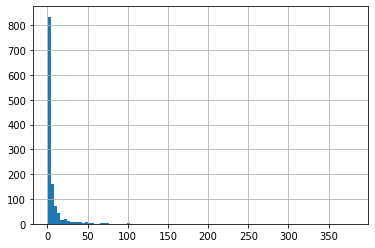

In [382]:
ingredient_conut['COUNT(ri.ingredient_id)'].hist(bins= 100)

In [383]:
# remove rare ingredients in considerations
rare_ingredients = set(ingredient_conut[ingredient_conut['COUNT(ri.ingredient_id)'] < 5]['ingredient_name'])

In [384]:
rare_ingredients

{'5 spice powder',
 '85 percent ground beef',
 '93% lean ground turkey meat',
 'Crema Mexicana',
 'Low Moisture Part-Skim Mozzarella Cheese',
 'Miso Soybean Paste',
 'Potato Starch Flour',
 'acorn squash',
 'aged balsamic vinegar',
 'ahi tuna steaks',
 'alcohol free vanilla flavor',
 'ale',
 'aleppo pepper',
 'allspice berries',
 'amaretti cookies',
 'amaretto liqueur',
 'anaheim chiles',
 'anchovy',
 'andouille sausage',
 'angel food cake',
 'angel hair',
 'angostura bitters',
 'anise seeds',
 'apple butter',
 'apple pie filling',
 'apricot preserves',
 'apricots',
 'arrowroot powder',
 'artichokes',
 'asiago',
 'asian dressing',
 'avocado oil',
 'baby beets',
 'baby bok choy',
 'baby carrots',
 'baby-back ribs',
 'bacon drippings',
 'baharat spice mix',
 'balsamic glaze',
 'bamboo shoots',
 'bartlett pear',
 'basmati rice',
 'bay scallops',
 'bean sprouts',
 'bean thread noodles',
 'bee pollen',
 'beef',
 'beef bouillon',
 'beef bouillon granules',
 'beef chuck roast',
 'beef consomm

In [386]:
# build edge list
from_node = []
to_node = []
d = []

for i in recipe_pmi.columns:
    for j in recipe_pmi.columns:
        if i in rare_ingredients or j in rare_ingredients:
            continue
        else:
            from_node.append(i)
            to_node.append(j)
            d.append(recipe_pmi.loc[i,j])

In [387]:
import numpy as np
ingredient_dist = pd.DataFrame({'from': from_node, 'to':to_node, 'distance' :d})
ingredient_dist = ingredient_dist[ingredient_dist['distance']!=0]
# ingredient_dist['distance'] = np.sqrt(1/ingredient_dist['distance'])

In [389]:
ingredient_dist = ingredient_dist.reset_index()
ingredient_dist

,index,from,to,distance
0,1,white wine vinegar,salt and pepper,0.000021
1,2,white wine vinegar,buttermilk,0.000065
2,3,white wine vinegar,fresh tarragon,0.000366
3,4,white wine vinegar,olive oil,0.000032
4,5,white wine vinegar,chicken breasts,0.000135
...,...,...,...,...
31367,156756,plain greek yogurt,apple cider vinegar,0.000062
31368,156763,plain greek yogurt,garam masala,0.000123
31369,156769,plain greek yogurt,yukon gold potatoes,0.000462
31370,156799,plain greek yogurt,coconut oil,0.000084


In [390]:
ingredient_dist['from'].value_counts()

salt                   364
garlic clove           320
eggs                   316
water                  316
granulated sugar       310
                      ... 
sugar syrup             18
sparkling water         17
multi grain bread       17
corn flakes             16
angel food cake mix     15
Name: from, Length: 396, dtype: int64

# Add nodes to graph

In [391]:
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx

In [392]:
nodes = set(ingredient_dist['from']).union(set(ingredient_dist['to'])) 
nodes

{'0% fat greek yogurt',
 'Spice Rub',
 'active yeast',
 'agave syrup',
 'almond extract',
 'almond flour',
 'almond milk',
 'almonds',
 'angel food cake mix',
 'apple',
 'apple cider',
 'apple cider vinegar',
 'apple juice',
 'artichoke hearts',
 'arugula',
 'asafoetida',
 'asparagus',
 'avocado',
 'baby bella mushrooms',
 'baby spinach leaves',
 'bacon',
 'baguette',
 'baking mix',
 'baking powder',
 'baking soda',
 'balsamic vinegar',
 'bananas',
 'basil',
 'basil pesto',
 'bay leaf',
 'bbq sauce',
 'beetroots',
 'bell pepper',
 'black beans',
 'black olives',
 'blackberries',
 'blueberries',
 'bread',
 'bread flour',
 'breadcrumbs',
 'broccoli',
 'broccoli florets',
 'brown rice',
 'brown sugar',
 'brussels sprouts',
 'butter',
 'buttermilk',
 'butternut squash',
 'cabbage',
 'cake flour',
 'canned beef broth',
 'canned black beans',
 'canned coconut milk',
 'canned tomatoes',
 'canola oil',
 'capers',
 'caramel topping',
 'cardamom',
 'carrots',
 'cashews',
 'cauliflower',
 'caulif

In [393]:
G = nx.Graph()

for i in nodes:
    G.add_node(i)

# Add edges to graph

In [394]:
ingredient_dist

,index,from,to,distance
0,1,white wine vinegar,salt and pepper,0.000021
1,2,white wine vinegar,buttermilk,0.000065
2,3,white wine vinegar,fresh tarragon,0.000366
3,4,white wine vinegar,olive oil,0.000032
4,5,white wine vinegar,chicken breasts,0.000135
...,...,...,...,...
31367,156756,plain greek yogurt,apple cider vinegar,0.000062
31368,156763,plain greek yogurt,garam masala,0.000123
31369,156769,plain greek yogurt,yukon gold potatoes,0.000462
31370,156799,plain greek yogurt,coconut oil,0.000084


### Only connect important edges

In [395]:
import networkx as nx

# threshold
q = ingredient_dist.quantile(0.95).loc['distance']

# for i in range(100):
for i in range(len(ingredient_dist)):
    if ingredient_dist.loc[i,'distance'] > q:
        G.add_edge(ingredient_dist.loc[i,'from'], ingredient_dist.loc[i,'to'], weight = ingredient_dist.loc[i,'distance'])


In [413]:
pos_ = nx.spring_layout(G)

In [414]:
pos_

{'lemon juice': array([ 0.88147188, -0.49327777]),
 'baking powder': array([0.31208194, 0.8814912 ]),
 'broccoli florets': array([0.58756664, 0.00973665]),
 'italian seasoned breadcrumbs': array([-0.23213226, -0.84667156]),
 'cornmeal': array([-0.91587269,  0.29375439]),
 'raspberries': array([-0.82958481, -0.17208337]),
 'cream of tartar': array([ 0.68411006, -0.69768898]),
 'peach': array([-0.82451237, -0.09788948]),
 'sesame seeds': array([ 0.2891455, -0.9358913]),
 'yukon gold potatoes': array([-0.3159776 , -0.41758487]),
 'green chile peppers': array([-0.94637097, -0.29991222]),
 'cilantro': array([0.20450813, 0.94909876]),
 'canned coconut milk': array([0.1255188 , 0.08783649]),
 'orange': array([-0.53856123, -0.05683735]),
 'egg yolk': array([-0.34259501,  0.92091364]),
 'pepper jack cheese': array([-0.49186281,  0.89027806]),
 'buttermilk': array([-0.81695641, -0.45150214]),
 'lean ground turkey': array([0.35537477, 0.86375108]),
 'cauliflower florets': array([0.17966163, 0.309

In [416]:
# add position attribute to node
for k,v in pos_.items():
    G.nodes[k]['pos'] = v

In [417]:
import mysql.connector
import pandas as pd

db = mysql.connector.connect(host='localhost',user='root',password='root', database='food_recommendation')

### Count ingredients occurences

In [418]:
ingredient_recipe_count = pd.read_sql(("""

SELECT COUNT(ri.ingredient_id), ingredient_name
FROM food_recommendation.recipe_ingredients ri JOIN food_recommendation.ingredients i
ON ri.ingredient_id = i.ingredient_id
GROUP BY ri.ingredient_id
ORDER BY COUNT(ri.ingredient_id) DESC;

"""), db)

In [419]:
ingredient_recipe_count

,COUNT(ri.ingredient_id),ingredient_name
0,380,salt
1,298,garlic clove
2,276,granulated sugar
3,270,eggs
4,234,olive oil
...,...,...
1226,1,ziti
1227,1,tri-color pasta
1228,1,maple extract
1229,1,rum extract


In [420]:
# store in dict for later use
ingredient_count_dict = {}

for i in range(len(ingredient_recipe_count)):
    ingredient_count_dict[ingredient_recipe_count.loc[i, 'ingredient_name']] = ingredient_recipe_count.loc[i, 'COUNT(ri.ingredient_id)']

In [421]:
ingredient_count_dict

{'salt': 380,
 'garlic clove': 298,
 'granulated sugar': 276,
 'eggs': 270,
 'olive oil': 234,
 'flour': 218,
 'butter': 217,
 'pepper': 212,
 'water': 191,
 'onion': 179,
 'vanilla': 149,
 'lemon juice': 140,
 'milk': 133,
 'baking powder': 105,
 'unsalted butter': 101,
 'brown sugar': 100,
 'kosher salt': 100,
 'salt and pepper': 95,
 'fresh parsley': 91,
 'scallions': 77,
 'baking soda': 76,
 'parmesan cheese': 75,
 'tomato': 73,
 'heavy cream': 72,
 'ground cinnamon': 68,
 'carrots': 67,
 'cilantro': 67,
 'honey': 67,
 'powdered sugar': 66,
 'canola oil': 58,
 'lime juice': 57,
 'fresh ginger root': 56,
 'basil': 55,
 'vegetable oil': 53,
 'sea-salt': 53,
 'cream cheese': 50,
 'oregano': 49,
 'lemon zest': 49,
 'nutmeg': 48,
 'ground cumin': 47,
 'garlic powder': 47,
 'red onion': 44,
 'sour cream': 43,
 'red pepper flakes': 42,
 'chile powder': 41,
 'cinnamon': 41,
 'red bell peppers': 41,
 'bell pepper': 41,
 'fresh thyme leaves': 40,
 'cornstarch': 40,
 'extra-virgin olive oil':

# Plot graph

In [423]:
import plotly.graph_objects as go
import networkx as nx
import numpy as np
# set node size
s = []

for i in G.nodes():
    s.append(ingredient_count_dict[i])
s = np.sqrt(s)*1.5

In [424]:
font_size = []
for i in G.nodes():
    font_size.append(ingredient_count_dict[i])
font_size = np.log(font_size)

In [425]:
name = list(G.nodes())

In [426]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.2, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text = name,
    textfont = {'size':s},
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Greens',
        reversescale=False,
        color=[],
        size=s,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [427]:
# set node hover
node_recipe_count = []
node_text = []

for i in G.nodes():
    node_recipe_count.append(ingredient_count_dict[i])
    node_text.append(i +': '+str(ingredient_count_dict[i]))

node_trace.marker.color = node_recipe_count
# node_trace.text = node_text

In [428]:
# plot diagram
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Food ingredient Network',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(

                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)),
                
                )



fig.show()